<a href="https://colab.research.google.com/github/hyunholee26/Martian-Challenge/blob/main/Martian_Challenge_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/library'
os.symlink('/content/drive/My Drive/My Drive/pre-installed-library/', my_path)
sys.path.insert(0, my_path)

In [5]:
import torch
import cv2
import json
import math
import copy
import time
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

In [6]:
# install pycocotools
!pip install -U pycocotools

# download the demo dataset. 
!wget -O geoai_demo.zip https://www.dropbox.com/s/zmmonm9ijrm4u9y/geoai_demo.zip?dl=1

# extract it to the current folder and remove the zip file
!unzip -qo geoai_demo.zip && rm geoai_demo.zip

# list files and directories
!ls ./demo/

!pwd
%cd demo
!pwd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-06-12 13:40:21--  https://www.dropbox.com/s/zmmonm9ijrm4u9y/geoai_demo.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/zmmonm9ijrm4u9y/geoai_demo.zip [following]
--2022-06-12 13:40:22--  https://www.dropbox.com/s/dl/zmmonm9ijrm4u9y/geoai_demo.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc177163a58618b9673f8ac36ab6.dl.dropboxusercontent.com/cd/0/get/BnE5gSWIy5u5APF2N8wBGWaip3IW106nsQlyE3pNKXCEqD2UPYaXTJWjDFgJHKr3Ra8QzUZQm2fWFDgGKZg7DCTl4mzZ4Sdiv2ekmKltGhw-YI4ikkx8pyYla2hWKLqz-xypLMs1UlzXfSORaIsVnmNmG16FDrTiQf0bor71b6qRdg/file?dl=1# [following]
--2022-06-12 13:40:22--  https://uc177163a58618b9673f8ac36

{'train': ['101398', '018197', '036424', '046139', '055557', '039019', '054921', '029306', '040505', '059359', '041615', '020869', '046308', '053302', '034169', '015420', '054248', '047588', '072908', '035022', '010851', '102002', '087819', '013947', '036086', '057256', '085792', '040800', '002737', '000243', '070652', '013517', '091555', '089559', '086485', '052741', '087377', '007803', '095084', '074699', '033233', '068584', '012702', '072390', '073172', '011461', '008149', '097663', '010789', '058912', '101414', '018102', '023941', '071570', '038160', '077788', '040767', '036618', '058242', '088954', '082852', '038310', '014934', '058620', '050481', '056414', '029034', '099956', '050505', '022230', '101124', '010535', '088627', '025906', '032088', '094096', '034425', '031133', '024938', '011118', '049459', '025684', '081903', '052280', '035777', '088139', '021100', '051940', '031985', '016696', '054833', '051282', '046641', '059494', '034843', '075594', '073789', '022438', '041516',

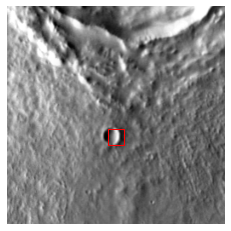

In [7]:
# function to show one image and its crater labels
def imshow(image, labels):
  fig, ax = plt.subplots()
  ax.imshow(image, cmap='gray')

  for box in labels:
    # box format: [xmin, ymin, width, height]
    rect = patches.Rectangle((box[0], box[1]), box[2], box[3], 
                             linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
  plt.axis('off')
  plt.show()

# load image IDs from ids_demo.json
image_ids = json.load(open("./ids_demo.json"))
print(image_ids)

# get IDs of the training set
train_set_ids = image_ids["train"]
print(train_set_ids)

# load one sample image
sample_image_id = train_set_ids[random.randrange(len(train_set_ids))]
sample_image = cv2.imread("./images/{}.png".format(sample_image_id))

# load crater labels from gt_public.json
labels = json.load(open("./gt_public.json"))

# load the label for the sample image 
sample_label = labels[sample_image_id]
print("image id: {}".format(sample_image_id))
imshow(sample_image, sample_label)

In [8]:
def get_object_detection_model(num_classes):
  model = models.detection.retinanet_resnet50_fpn(num_classes=num_classes)
  return model

In [9]:
class CraterDataset(Dataset):
  def __init__(self, phase, data_transforms):
    self.transform = data_transforms
    # load image IDs of training set or validation set
    self.img_ids = json.load(open('./ids_demo.json'))[phase]
    # load all crater bounding boxes
    self.crater_boxes = json.load(open('./gt_public.json'))


  def __getitem__(self, idx): 
    img_id = self.img_ids[idx]
    # load the image
    img = cv2.imread("./images/{}.png".format(img_id)) 
    # get bounding boxes and transfer it 
    # from [xmin, ymin, width, height] to [xmin, ymin, xmax, ymax] 
    crater_boxes = self.crater_boxes[img_id]
    num_craters = len(crater_boxes)
    boxes = []
    for box in crater_boxes:
        xmin = box[0]
        xmax = box[0] + box[2]
        ymin = box[1]
        ymax = box[1] + box[3]
        boxes.append([xmin, ymin, xmax, ymax])

    # tranfser to requested data type
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    # the class of all boxes is the same. 0: background 1: crater
    labels = torch.ones((num_craters,), dtype=torch.int64)
    # wrap up as a dictionary 
    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    # data transform 
    if self.transform is not None:
        img = self.transform(img)

    return img, target
    
  
  def __len__(self):
    return len(self.img_ids)

In [10]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [11]:
def train_model(model, optimizer, dataset, data_loader, num_epochs=10):
  since = time.time()
  # check if gpu is available
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  print('training with gpu...' if torch.cuda.is_available() else 'trining with cpu...')
  # store best model weights
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 100000
  model.train()

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      running_loss = 0.0

      # iterate over data
      for images, targets in data_loader[phase]:
        # transfer data into requested input format of RetinaNet
        # transfer data to gpu if available
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # loss calculation
        losses = model(images, targets)
        losses = sum(loss for loss in losses.values())

        # update the model only in the training phase
        # gradient back propagation + model parameters update
        if phase == 'train':
          optimizer.zero_grad()
          losses.backward()
          optimizer.step()
        # accumulate loss values
        running_loss += losses.item() * len(images)
      
      # average loss   
      epoch_loss = running_loss / len(dataset[phase])
      print('{} loss: {:.4f}'.format(phase, epoch_loss))

      # select the best model in the validation phase
      # copy the model weights if loss is smaller
      if phase == 'val' and epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
          
    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
  print('Best validation loss: {:4f}'.format(best_loss))
  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [12]:
# initialize a model with numer of classes = 2
model = get_object_detection_model(2)

# define data tranformation function
data_transforms = transforms.Compose([transforms.ToTensor()])

# define dataset and dataloader for training for debug set
dataset = {x: CraterDataset(x, data_transforms) for x in ['train', 'val']}
data_loader = {x: DataLoader(dataset[x], batch_size=8, 
                             shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
for x in ['train', 'val']}

# transfer the model to gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# define optimization algorithm
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# train model
model = train_model(model, optimizer, dataset, data_loader, num_epochs=20)

training with gpu...
Epoch 0/19
----------
train loss: 1.8426
val loss: 1.8049

Epoch 1/19
----------
train loss: 1.7081
val loss: 1.6062

Epoch 2/19
----------
train loss: 1.5865
val loss: 1.6320

Epoch 3/19
----------
train loss: 1.5979
val loss: 1.4766

Epoch 4/19
----------
train loss: 1.6061
val loss: 1.5060

Epoch 5/19
----------
train loss: 1.7189
val loss: 1.6471

Epoch 6/19
----------
train loss: 1.6350
val loss: 1.5954

Epoch 7/19
----------
train loss: 1.5279
val loss: 1.4609

Epoch 8/19
----------
train loss: 1.4916
val loss: 1.7038

Epoch 9/19
----------
train loss: 1.6589
val loss: 1.6251

Epoch 10/19
----------
train loss: 1.6297
val loss: 1.6169

Epoch 11/19
----------
train loss: 1.6243
val loss: 1.6148

Epoch 12/19
----------
train loss: 1.6212
val loss: 1.6130

Epoch 13/19
----------
train loss: 1.6201
val loss: 1.6100

Epoch 14/19
----------
train loss: 1.6163
val loss: 1.6072

Epoch 15/19
----------
train loss: 1.6133
val loss: 1.6053

Epoch 16/19
----------
train 

tensor([], device='cuda:0')
image id: 016330


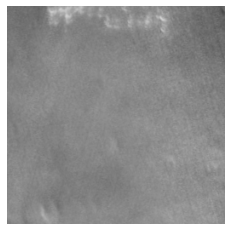

In [13]:
# set the model in the evaluation model
model.eval()

# load testing image IDs
test_img_ids = json.load(open('./ids_demo.json'))['test']

# load one sample image
test_img_id = test_img_ids[random.randrange(len(test_img_ids))]
test_img = cv2.imread('./images/{}.png'.format(test_img_id))

# apply data transformation ToTensor() and send the image to gpu if available
transformed_test_img = data_transforms(test_img)
transformed_test_img = transformed_test_img.to(device)

# turn of the gradient computation and make prediction
with torch.no_grad():
  prediction = model([transformed_test_img])

# keep boxes with scores >= 0.5
boxes = prediction[0]["boxes"]
scores = prediction[0]["scores"]
boxes = boxes[scores >= 0.5, :]
print(scores)

# box format transformation
boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

# plot image
print("image id: {}".format(test_img_id))
imshow(test_img, boxes)

In [14]:
# set the model in evaluation model                                
model.eval()

# load image IDs of the validation set
val_img_ids = json.load(open('./ids_demo.json'))['val']
detection_results = {}

# iterate over the validation set
for img_id in val_img_ids:
  val_img = cv2.imread('./images/{}.png'.format(img_id))
  # apply data transformation ToTensor() and send the image to gpu if available
  transformed_val_img = data_transforms(val_img)
  transformed_val_img = transformed_val_img.to(device)
  # turn of the gradient computation and make prediction
  with torch.no_grad():
    prediction = model([transformed_val_img])

  # box format transformation
  boxes = prediction[0]["boxes"]
  boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
  boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
  scores = prediction[0]["scores"]
  scores = torch.reshape(scores, (-1,1))
  # concatenate boxes and scores
  # the result format is [xmin, ymin, width, height, score]
  boxes_scores = torch.cat((boxes, scores), dim=1)
  # transfer to list and store in the dictionary 
  boxes_scores = boxes_scores.cpu().numpy().tolist()
  detection_results[img_id] = boxes_scores


In [15]:
# import evaluate function
import sys
from evaluate import evaluate

print('evaluation metrics: ')
metrics = evaluate(detection_results, val_img_ids)
print()
print('the list of evaluation values: {}'.format(metrics))

evaluation metrics: 
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | 

In [16]:
# set the model in evaluation model                                
model.eval()
# load image IDs of the testing set
test_img_ids = json.load(open('./ids_demo.json'))['test']
detection_results = {}

# iterate over the testing set
for img_id in test_img_ids:
  test_img = cv2.imread('./images/{}.png'.format(img_id))
  # apply data transformation ToTensor() and send the image to gpu if available
  transformed_test_img = data_transforms(test_img)
  transformed_test_img = transformed_test_img.to(device)
  # turn of the gradient computation and make prediction
  with torch.no_grad():
    prediction = model([transformed_test_img])

  # box format transformation
  boxes = prediction[0]["boxes"]
  boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
  boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
  scores = prediction[0]["scores"]
  scores = torch.reshape(scores, (-1,1))
  # concatenate boxes and scores
  # the result format is [xmin, ymin, width, height, score]
  boxes_scores = torch.cat((boxes, scores), dim=1)
  # transfer to list and store in the dictionary 
  boxes_scores = boxes_scores.cpu().numpy().tolist()
  detection_results[img_id] = boxes_scores

# save the result to file
with open('detection_results.json', 'w') as f:
  json.dump(detection_results, f)

# zip the result
!zip detection_results.zip detection_results.json

  adding: detection_results.json (deflated 65%)
